## Generating a Rating with the help of Comment Analysis and Machine Learning

### 1) Preprocessing the Comment Data

**Import pandas and warnings**

In [1]:
import pandas as pd
import warnings
warnings.filterwarnings("ignore")

**Reading the dataset and checking the first 5 rows**

In [2]:
comments = pd.read_csv("udemy_courses/Comments.csv")

In [3]:
comments.head()

,id,course_id,rate,date,display_name,comment
0,88962892,3173036,1.0,2021-06-29T18:54:25-07:00,Rahul,I think a beginner needs more than you think.\...
1,125535470,4913148,5.0,2022-10-07T11:17:41-07:00,Marlo,Aviva is such a natural teacher and healer/hea...
2,68767147,3178386,3.5,2020-10-19T06:35:37-07:00,Yamila Andrea,Muy buena la introducción para entender la bas...
3,125029758,3175814,5.0,2022-09-30T21:13:49-07:00,Jacqueline,This course is the best on Udemy. This breakd...
4,76584052,3174896,4.5,2021-01-30T08:45:11-08:00,Anthony,I found this course very helpful. It was full ...


* There are plenty of character sequences that indicates the empty comment such as ".", "?", ",", "-", ":)", "..", "...", "???", .... etc. 
* These characters are the obstacles in front of the language detector. When it sees these characters, it gives an error.

**Saving the comment ratings with certain intervals to another data frame**

In [4]:
comment_1 = comments[comments["rate"] <= 1] # Interval [0,1]
comment_2 = comments[(comments["rate"] > 1) & (comments["rate"] <= 2)] # Interval (1,2]
comment_3 = comments[(comments["rate"] > 2) & (comments["rate"] <= 3)] # Interval (2,3]
comment_4 = comments[(comments["rate"] > 3) & (comments["rate"] <= 4)] # Interval (3,4]
comment_5 = comments[comments["rate"] > 4] # Interval (4,5]

**Calculating the length of each of them**

In [5]:
rate_1 = len(comment_1) / len(comments)*100
rate_2 = len(comment_2) / len(comments)*100
rate_3 = len(comment_3) / len(comments)*100
rate_4 = len(comment_4) / len(comments)*100
rate_5 = len(comment_5) / len(comments)*100

* These lengths will be used to learn how the comment ratings distributed 

**Printing the percentage of the comment ratings for each interval**

In [6]:
print(f"Percentage of comments rated below 1.0 is {rate_1}")
print(f"Percentage of comments rated above 1.0 and below 2.0 is {rate_2}")
print(f"Percentage of comments rated above 2.0 and below 3.0 is {rate_3}")
print(f"Percentage of comments rated above 3.0 and below 4.0 is {rate_4}")
print(f"Percentage of comments rated above 4.0 is {rate_5}")

Percentage of comments rated below 1.0 is 1.9963392478341118
Percentage of comments rated above 1.0 and below 2.0 is 1.605645807618517
Percentage of comments rated above 2.0 and below 3.0 is 5.4198129631256835
Percentage of comments rated above 3.0 and below 4.0 is 16.539791262538746
Percentage of comments rated above 4.0 is 74.43841071888293


* In order to get better visual, we will plot pie graph

**Plotting pie graph with plt.pie**

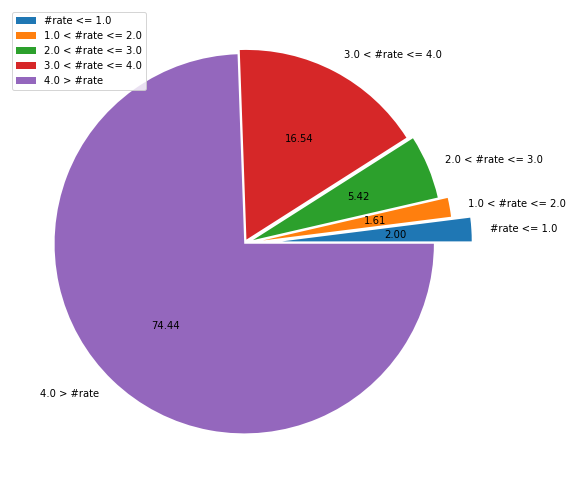

In [7]:
import matplotlib.pyplot as plt
plt.figure(figsize = (8,8))
data = [rate_1, rate_2, rate_3, rate_4, rate_5]
labels = ["#rate <= 1.0", "1.0 < #rate <= 2.0", "2.0 < #rate <= 3.0", "3.0 < #rate <= 4.0", "4.0 > #rate"]
plt.pie(data, labels=labels, autopct='%.2f', explode=[0.2,0.1,0.05,0.025,0])
plt.tight_layout()
plt.legend()

* Dataset is highly imbalanced
* 75% of the comments are rated with higher than 4
* We need to take equal number of samples for each interval
* Because such an imbalanced data will bring challenges to seperate rating intervals, and results in poor model performance.

* For the sake of convenience, we will choose 5000 comments of each rating interval. (Undersampling)

**Selecting 5000 samples from each rating intervals and dropping the null values**

In [8]:
comment_1_sample = comment_1.sample(5000, random_state=1).dropna()
comment_2_sample = comment_2.sample(5000, random_state=1).dropna()
comment_3_sample = comment_3.sample(5000, random_state=1).dropna()
comment_4_sample = comment_4.sample(5000, random_state=1).dropna()
comment_5_sample = comment_5.sample(5000, random_state=1).dropna()

In [9]:
comment_1_sample.head()

,id,course_id,rate,date,display_name,comment
677568,76904362,124862,1.0,2021-02-03T06:02:58-08:00,Prathamesh,worst
2844211,73905032,3016360,1.0,2020-12-29T23:42:18-08:00,Amit Kumar,Not a good teacher
8102772,116787574,1506888,1.0,2022-06-20T02:23:29-07:00,Deepak,dont waste your money
1907760,44653686,2531702,1.0,2020-01-30T03:27:19-08:00,Dear,offensive course. ?
350195,6514276,967674,0.5,2017-04-18T15:36:01-07:00,Mathew S,SwiftyStoreKit is already a clean lightweight ...


**At this step, we will filter out the comments which have less than 20 characters**

**This function will detect the short comments and save their indexes to a list**

In [10]:
def short_comments_detect(df):
    short_coms_idx = []
    for i in range(len(df["comment"])):
        if len(df["comment"].values[i]) < 20:
            short_coms_idx.append(df["comment"].index[i])
    return short_coms_idx

* Index list will be used to delete the corresponding values

**A function has written to delete the short comments**

In [11]:
def delete_short_coms(df, idx):
    new_df = df.drop(idx)
    return new_df

**This function will prevent the code repetitions by executing the deletion operation for each rating intervals**

In [12]:
def auto_process_1(df):
    short_coms = short_comments_detect(df)
    long_coms = delete_short_coms(df, short_coms)
    return long_coms

**Deleting the short comments and save them to the new data frame**

In [13]:
sample_1_long = auto_process_1(comment_1_sample)
sample_2_long = auto_process_1(comment_2_sample)
sample_3_long = auto_process_1(comment_3_sample)
sample_4_long = auto_process_1(comment_4_sample)
sample_5_long = auto_process_1(comment_5_sample)

**At this step, we will filter out the comments which has not written in English by using *langdetect* library**

In [14]:
!pip install langdetect

In [15]:
from langdetect import detect

**This function will detect the comments which have not written in English, and save their indexes to a list**

In [16]:
def foreign_comments_detect(df):
    foreign_idx = []
    for i in range(len(df["comment"])):
        comment = df["comment"].values[i]
        if detect(comment) != "en":
            foreign_idx.append(df["comment"].index[i])
    return foreign_idx

* Index list will be used to delete the corresponding values

**These data frames are containing the comments has not written with English**

In [17]:
foreign_1 = foreign_comments_detect(sample_1_long)
foreign_2 = foreign_comments_detect(sample_2_long)
foreign_3 = foreign_comments_detect(sample_3_long)
foreign_4 = foreign_comments_detect(sample_4_long)
foreign_5 = foreign_comments_detect(sample_5_long)

In [18]:
sample_1_long.loc[foreign_1].head()

,id,course_id,rate,date,display_name,comment
3650519,96722050,1996964,1.0,2021-09-29T16:04:32-07:00,William Alexander,"No muestra nada nuevo de VB.NET, utiliza progr..."
1914910,48817558,1152028,1.0,2020-03-29T20:10:21-07:00,Scarlet,Publicidad engañosa desactualizado dice que e...
1170625,47353196,2006722,1.0,2020-03-15T12:20:26-07:00,Onur,ne yaptığını nerede ise anlatmıyor yapıp geçiyor
996714,116931536,3659640,1.0,2022-06-21T14:13:17-07:00,Mauricio lobianco,só apresentou as guias e comandos que qq um qu...
2346256,61841902,1777698,1.0,2020-07-21T11:09:34-07:00,Jorge Arturo,"Falta de actualizacion, ya no coincide con lo ..."


**This function will prevent the code repetitions by executing the deletion operation for each rating intervals**

In [19]:
def auto_process_2(df, foreigners):
    new_df = df.drop(foreigners)
    return new_df

**Deleting the comments has not written in English and save them to the new data frame**

In [20]:
# This process is taking some time
sample_1_english = auto_process_2(sample_1_long, foreign_1)
sample_2_english = auto_process_2(sample_2_long, foreign_2)
sample_3_english = auto_process_2(sample_3_long, foreign_3)
sample_4_english = auto_process_2(sample_4_long, foreign_4)
sample_5_english = auto_process_2(sample_5_long, foreign_5)

**Plotting the pie graph to see the data is balanced or not**

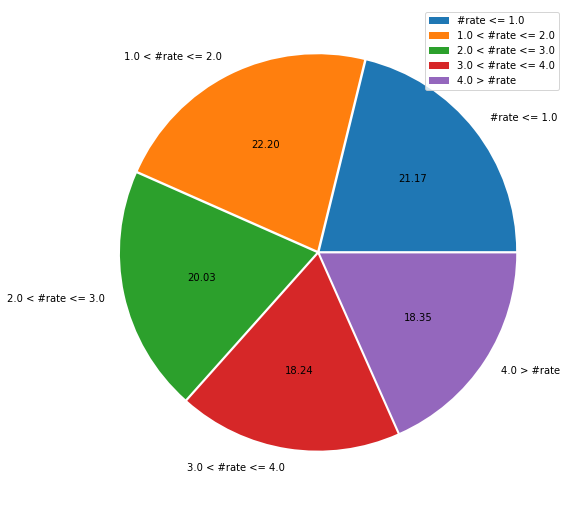

In [21]:
plt.figure(figsize = (8,8))
data = [len(sample_1_english), len(sample_2_english), len(sample_3_english), len(sample_4_english), len(sample_5_english)]
labels = ["#rate <= 1.0", "1.0 < #rate <= 2.0", "2.0 < #rate <= 3.0", "3.0 < #rate <= 4.0", "4.0 > #rate"]
plt.pie(data, labels=labels, autopct='%.2f', explode=[0.01,0.01,0.01,0.01,0.01])
plt.tight_layout()
plt.legend()

* Our data is more balanced now

**We need to concatenate these data with different rating intervals into a new data frame anymore.**

In [22]:
all_comments = pd.concat([sample_1_english[["comment", "rate"]], 
                          sample_2_english[["comment", "rate"]],
                          sample_3_english[["comment", "rate"]],
                          sample_4_english[["comment", "rate"]],
                          sample_5_english[["comment", "rate"]]])
all_comments.head()

,comment,rate
8102772,dont waste your money,1.0
350195,SwiftyStoreKit is already a clean lightweight ...,0.5
2953887,It's not dynamic.... and it's not for beginners,1.0
4321094,Starts with showing how to install Python 2 an...,0.5
5824927,Provide almost no practical advice on nothing....,1.0


* Looks good, but we need to do one more thing which is quite significant, **shuffling**
* Without shuffling, it is highly possible to train your model with rating intervals less than 4, and test this model with rating interval higher than 4
* In such case, it is not possible to gain the generalization property of the model

**Shuffling the data and resetting the indexes**

In [23]:
comments_shuffled = all_comments.sample(frac=1, random_state=1).reset_index().drop(["index"], axis=1)

In [24]:
comments_shuffled.head(10)

,comment,rate
0,quite difficult to understand because of his a...,1.5
1,Outdated and no actual info. \nNot relevant an...,1.0
2,This was a great reminder to be mindful of tho...,4.0
3,"This is just a overview of ABAP on HANA, I did...",1.0
4,he is not a good instructor,2.0
5,I took this course for free and I also saw it'...,3.5
6,It's not CC 2018. makes it difficult to follow...,3.0
7,Volume was only clear on last section,3.0
8,Sometimes if feels frustrating to hear a lectu...,1.0
9,Author didnot explain detail in maximum topics...,2.0


**Lowercasing all of the words to decrease the variation**

In [25]:
comments_shuffled["comment"] = comments_shuffled["comment"].apply(lambda txt: txt.lower())

In [26]:
comments_shuffled.head(10)

,comment,rate
0,quite difficult to understand because of his a...,1.5
1,outdated and no actual info. \nnot relevant an...,1.0
2,this was a great reminder to be mindful of tho...,4.0
3,"this is just a overview of abap on hana, i did...",1.0
4,he is not a good instructor,2.0
5,i took this course for free and i also saw it'...,3.5
6,it's not cc 2018. makes it difficult to follow...,3.0
7,volume was only clear on last section,3.0
8,sometimes if feels frustrating to hear a lectu...,1.0
9,author didnot explain detail in maximum topics...,2.0


**This function will extract number from the comments**

In [27]:
import re
def leave_only_words(comment):
    for idx in range(len(comment)):
        comments_shuffled["comment"][idx] = re.sub(r'[^a-zA-Z ]+', '', comments_shuffled["comment"][idx])

**Calling the function**

In [28]:
%%time
leave_only_words(comments_shuffled["comment"])

Wall time: 9.22 s


**Why did not we remove stopwords?**

**Before deletion of stopwords**

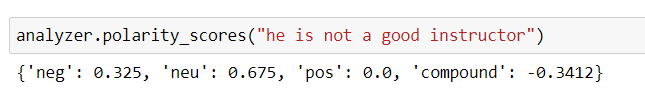

**After deletion of stopwords**

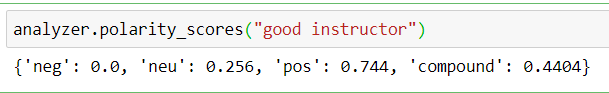

* You can see the difference. The result is almost reversed

**We will install and use vaderSentiment library to analyse the comments**

In [29]:
! pip install vaderSentiment

***SentimentIntensityAnalyzer* will analyse the comments and return a dict which contains scores such as:**
  *  ***Negative(neg):* Negativity value of the comment**  
  *  ***Neutral(neu):* Neutrality value of the comment**  
  *  ***Positive(pos):* Positivity value of the comment**  
  *  ***Compound(compound):* Compound value of the comment**  

In [30]:
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
analyzer = SentimentIntensityAnalyzer()

* **This algorithm constructed from a dictionary that contains a comprehensive list of sentiment features.**
* **All the lexical features were rated for the polarity and intensity on a scale from “-4: Extremely Negative” to “+4 Extremely Positive” by 10 independent human raters.**
* **For example, in Vader, the word “okay” has a positive rating of 0.9, “good” is 1.9 and “great” is 3.1, whereas “horrible” is -2.5**
* **Vader’s lexicon dictionary contains around 7,500 sentiment features in total and any word not listed in the dictionary will be scored as “0: Neutral”.**
* **The compound score is computed by summing the valence scores of each word in the lexicon, adjusted according to the rules, and then normalized to be between -1 (most extreme negative) and +1 (most extreme positive).**

**Applying the sentiment analyse algorithm and saving the results into the "scores" column**

In [31]:
comments_shuffled["scores"] = comments_shuffled["comment"].apply(lambda txt: analyzer.polarity_scores(txt))

In [32]:
comments_shuffled.head(10)

,comment,rate,scores
0,quite difficult to understand because of his a...,1.5,"{'neg': 0.285, 'neu': 0.715, 'pos': 0.0, 'comp..."
1,outdated and no actual info not relevant anymore,1.0,"{'neg': 0.239, 'neu': 0.761, 'pos': 0.0, 'comp..."
2,this was a great reminder to be mindful of tho...,4.0,"{'neg': 0.0, 'neu': 0.83, 'pos': 0.17, 'compou..."
3,this is just a overview of abap on hana i didn...,1.0,"{'neg': 0.09, 'neu': 0.784, 'pos': 0.126, 'com..."
4,he is not a good instructor,2.0,"{'neg': 0.325, 'neu': 0.675, 'pos': 0.0, 'comp..."
5,i took this course for free and i also saw its...,3.5,"{'neg': 0.0, 'neu': 0.685, 'pos': 0.315, 'comp..."
6,its not cc makes it difficult to follow along,3.0,"{'neg': 0.238, 'neu': 0.762, 'pos': 0.0, 'comp..."
7,volume was only clear on last section,3.0,"{'neg': 0.0, 'neu': 0.698, 'pos': 0.302, 'comp..."
8,sometimes if feels frustrating to hear a lectu...,1.0,"{'neg': 0.051, 'neu': 0.805, 'pos': 0.145, 'co..."
9,author didnot explain detail in maximum topics...,2.0,"{'neg': 0.0, 'neu': 0.898, 'pos': 0.102, 'comp..."


**Saving the sub-scores to the corresponding columns seperately**

In [33]:
comments_shuffled["negative"] = comments_shuffled["scores"].apply(lambda txt: txt["neg"])
comments_shuffled["neutral"] = comments_shuffled["scores"].apply(lambda txt: txt["neu"])
comments_shuffled["positive"] = comments_shuffled["scores"].apply(lambda txt: txt["pos"])
comments_shuffled["compound"] = comments_shuffled["scores"].apply(lambda txt: txt["compound"])

**Dropping the "comment" and "scores" columns and exchange the remaining columns' order**

In [34]:
comment_scores = comments_shuffled.drop(["comment", "scores"], axis=1)[["negative", "neutral", "positive", "compound", "rate"]]

In [35]:
comment_scores.head(10)

,negative,neutral,positive,compound,rate
0,0.285,0.715,0.000,-0.4201,1.5
1,0.239,0.761,0.000,-0.2960,1.0
2,0.000,0.830,0.170,0.6249,4.0
3,0.090,0.784,0.126,0.2427,1.0
4,0.325,0.675,0.000,-0.3412,2.0
5,0.000,0.685,0.315,0.9661,3.5
6,0.238,0.762,0.000,-0.3612,3.0
7,0.000,0.698,0.302,0.3818,3.0
8,0.051,0.805,0.145,0.6557,1.0
9,0.000,0.898,0.102,0.3612,2.0


* Preprocessing step is done
* Our data is ready to be modeled

### 2) Regression Modeling

**Importing libraries**

In [36]:
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor 
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR
from sklearn.metrics import mean_squared_error

* **This function takes 3 arguments as data, regressor, and scale**
* **It will split the data to train and test**
* **If there is a scaler defined in the argument, then it will scale the data with the corresponding scaler type (min-max or standard scaler)**
* **After that, it trains the model which is also sent as an argument and makes the prediction over test data**
* **Lastly, it will calculate the RMSE score and return the model with all train and test data**

In [37]:
def sample_model(df, regressor, scale=None):
    X = df.drop("rate",axis=1)
    y = df["rate"]
    
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state=1)
    scaled_X_train, scaled_X_test = X_train, X_test
    if scale != None:
        scaler = scale
        scaled_X_train = pd.DataFrame(scaler.fit_transform(X_train), columns = X_train.columns)
        scaled_X_test = pd.DataFrame(scaler.transform(X_test),columns = X_test.columns)
    
    model = regressor
    model.fit(scaled_X_train, y_train)
    y_pred = model.predict(scaled_X_test)
    
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    print(f"Root Mean Squared Error(RMSE) for {regressor} is {rmse:.3f}")
    
    return model, scaled_X_train, scaled_X_test, y_train, y_test 

**There will be 4 different regression models we will deploy**

**Deploying the models without scaling**

In [38]:
lr = sample_model(comment_scores, LinearRegression())
dec_tree = sample_model(comment_scores, DecisionTreeRegressor(random_state=1))
rf = sample_model(comment_scores, RandomForestRegressor(random_state=1))
svr = sample_model(comment_scores, SVR())

Root Mean Squared Error(RMSE) for LinearRegression() is 1.108
Root Mean Squared Error(RMSE) for DecisionTreeRegressor(random_state=1) is 1.377
Root Mean Squared Error(RMSE) for RandomForestRegressor(random_state=1) is 1.147
Root Mean Squared Error(RMSE) for SVR() is 1.088


* SVR performed better than the others

**Deploying the models with Normalization(MinMaxScaler)**

In [39]:
lr = sample_model(comment_scores, LinearRegression(), MinMaxScaler())
dec_tree = sample_model(comment_scores, DecisionTreeRegressor(random_state=1), MinMaxScaler())
rf = sample_model(comment_scores, RandomForestRegressor(random_state=1), MinMaxScaler())
svr = sample_model(comment_scores, SVR(), MinMaxScaler())

Root Mean Squared Error(RMSE) for LinearRegression() is 1.108
Root Mean Squared Error(RMSE) for DecisionTreeRegressor(random_state=1) is 1.376
Root Mean Squared Error(RMSE) for RandomForestRegressor(random_state=1) is 1.147
Root Mean Squared Error(RMSE) for SVR() is 1.089


* SVR again performed better but a little weak than the previous case

**Deploying the models with Standardization(StandardScaler)**

In [40]:
lr = sample_model(comment_scores, LinearRegression(), StandardScaler())
dec_tree = sample_model(comment_scores, DecisionTreeRegressor(random_state=1), StandardScaler())
rf = sample_model(comment_scores, RandomForestRegressor(random_state=1), StandardScaler())
svr = sample_model(comment_scores, SVR(), StandardScaler())

Root Mean Squared Error(RMSE) for LinearRegression() is 1.108
Root Mean Squared Error(RMSE) for DecisionTreeRegressor(random_state=1) is 1.378
Root Mean Squared Error(RMSE) for RandomForestRegressor(random_state=1) is 1.148
Root Mean Squared Error(RMSE) for SVR() is 1.090


* Performance of SVR decreased but other ones' decreased as well

* The best algorithm is SVR without using any scaling

**Fitting the model by calling the function**

In [41]:
best_model, X_train, X_test, y_train, y_test = sample_model(comment_scores, SVR())

Root Mean Squared Error(RMSE) for SVR() is 1.088


**Hyperparameter Tuning**

In [42]:
from sklearn.model_selection import RepeatedKFold, GridSearchCV

**Defining some possible values for several parameters and saving them to the parameters dict**

In [43]:
kernel = ["linear", "rbf", "sigmoid", "poly"]
tolerance = [1e-3, 1e-4, 1e-5, 1e-6]
C = [1, 1.5, 2, 2.5, 3]
params = dict(kernel=kernel, tol=tolerance, C=C)

**5-fold cross validation with 3 repeats is processed**

In [47]:
"""
%%time
cvFold = RepeatedKFold(n_splits=5, n_repeats=3, random_state=1)
gridSearch = GridSearchCV(estimator=best_model, param_grid=params, n_jobs=-1, cv=cvFold)
searchResults = gridSearch.fit(X_train, y_train)
"""
# Execution time of this code: 1h 22min 59s
# Therefore, we executed this cell and commented all of it after we obtained the best parameters

Wall time: 1h 22min 59s


**Printing the cross-validation results**

In [48]:
print(" Results from Grid Search " )
print("The best estimator across ALL searched params: ",searchResults.best_estimator_)
print("The best score across ALL searched params: ",searchResults.best_score_)
print("The best parameters across ALL searched params: ",searchResults.best_params_)

 Results from Grid Search 
The best estimator across ALL searched params:  SVR(C=3)
The best score across ALL searched params:  0.39303741179275736
The best parameters across ALL searched params:  {'C': 3, 'kernel': 'rbf', 'tol': 0.001}


**Saving the best hyperparameters**

In [52]:
best_params = searchResults.best_params_
best_params

{'C': 3, 'kernel': 'rbf', 'tol': 0.001}

Best Parameters for SVR()
* C : 3
* kernel : "rbf"
* tol : "0.001"

**Fitting the tuned model and calculating the RMSE**

In [38]:
tuned_svr, _, _, _, _ = sample_model(comment_scores, SVR(C=3, kernel="rbf", tol=0.001))

Root Mean Squared Error(RMSE) for SVR(C=3) is 1.083


* RMSE is decreased by 0.001
* Did not worth it actually

### 3) Testing With User Interaction

**This function will take comment as an argument and calculate the rating by using the model which we tuned previously**

In [39]:
def user_interaction(comment, model):
    
    negative_score = analyzer.polarity_scores(comment)["neg"]
    neutral_score = analyzer.polarity_scores(comment)["neu"]
    positive_score = analyzer.polarity_scores(comment)["pos"]
    compound_score = analyzer.polarity_scores(comment)["compound"]
    rate_pred = model.predict([[negative_score, neutral_score, positive_score, compound_score]])
    
    print(f"\nYour Comment: {comment}\n")
    print("*"*10 + "Analysis of the Comment" + "*"*10)
    print("-"*10 + f"Negativity Score: {negative_score:.2f}" + "-"*10)
    print("-"*10 + f"Neutrality Score: {neutral_score:.2f}" + "-"*10)
    print("-"*10 + f"Positivity Score: {positive_score:.2f}" + "-"*10)
    print("-"*10 + f"Compound Score: {compound_score:.2f}" + "-"*10)
    print("*"*43)
    print("\nThe estimated rating this comment can give")
    print("*"*20 + str(round(rate_pred[0], 2)) + "*"*20)

**This function will take an input from the user. Comments must be written in English and longer than 20 characters**

In [40]:
def take_input(model):
    comment = input("Thanks for your interest and taking your time.\n"+
                    "Tell us about your personal experience enrolling in this course. Was it the right match for you?\n"+
                    "(Note: Comment should be written in English and be longer than 20 characters)\n")
    if (detect(comment) != "en") or (len(comment) < 20):
        print("Sorry, your comment does not meet the requirements.\n")
        take_input(model)
    else:
        user_interaction(comment, model)

**Example execution**

In [120]:
# take_input(tuned_svr)

Thanks for your interest and taking your time.
Tell us about your personal experience enrolling in this course. Was it the right match for you?
(Note: Comment should be written in English and be longer than 20 characters)
very good
Sorry, your comment does not meet the requirements.

Thanks for your interest and taking your time.
Tell us about your personal experience enrolling in this course. Was it the right match for you?
(Note: Comment should be written in English and be longer than 20 characters)
anlatımı gayet güzel
Sorry, your comment does not meet the requirements.

Thanks for your interest and taking your time.
Tell us about your personal experience enrolling in this course. Was it the right match for you?
(Note: Comment should be written in English and be longer than 20 characters)
because so far it’s good to understand.	

Your Comment: because so far it’s good to understand.	

**********Analysis of the Comment**********
----------Negativity Score: 0.00----------
----------Ne

C:\Users\DELL\anaconda3\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but SVR was fitted with feature names
  warnings.warn(


* After some testing, we realized that some comments predicted not much low or high even we enter such comments implies perfect course or awful course

* In order to examine how much the model predicts correctly for each rating interval, we will make predictions for each of them

### 4) Model Improvements

**This function will execute this process and calculate the average score that predicted for all of the comments in the rating interval**

In [41]:
def rate_interval_avg(df):
    predicts = []
    for comment in list(df["comment"].values):
        negative_score = analyzer.polarity_scores(comment)["neg"]
        neutral_score = analyzer.polarity_scores(comment)["neu"]
        positive_score = analyzer.polarity_scores(comment)["pos"]
        compound_score = analyzer.polarity_scores(comment)["compound"]
        rate_pred = tuned_svr.predict([[negative_score, neutral_score, positive_score, compound_score]])
        predicts.append(rate_pred)
    return sum(predicts)/ len(predicts)

**Function calling for each interval. It took some time. So that we commented all of it**

In [144]:
"""
avg_pred_rate_1 = rate_interval_avg(sample_1_english)
avg_pred_rate_2 = rate_interval_avg(sample_2_english)
avg_pred_rate_3 = rate_interval_avg(sample_3_english)
avg_pred_rate_4 = rate_interval_avg(sample_4_english)
avg_pred_rate_5 = rate_interval_avg(sample_5_english)
"""

**These are the actual average ratings for each rating interval**

In [48]:
act_avg_rate_1 = sample_1_english["rate"].mean()
act_avg_rate_2 = sample_2_english["rate"].mean()
act_avg_rate_3 = sample_3_english["rate"].mean()
act_avg_rate_4 = sample_4_english["rate"].mean()
act_avg_rate_5 = sample_5_english["rate"].mean()

**This cell will print the average of predicted ratings and average of actual ratings for each rating intervals**

In [147]:
print("-"*80)
print(f"The predicted average rate of comments which are rated in intervals 0-1 is: {avg_pred_rate_1}")
print(f"The actual average rate of comments which are rated in intervals 0-1 is: {act_avg_rate_1}")
print("-"*80)
print(f"The predicted average rate of comments which are rated in intervals 1-2 is: {avg_pred_rate_2}")
print(f"The actual average rate of comments which are rated in intervals 1-2 is: {act_avg_rate_2}")
print("-"*80)
print(f"The predicted average rate of comments which are rated in intervals 2-3 is: {avg_pred_rate_3}")
print(f"The actual average rate of comments which are rated in intervals 2-3 is: {act_avg_rate_3}")
print("-"*80)
print(f"The predicted average rate of comments which are rated in intervals 3-4 is: {avg_pred_rate_4}")
print(f"The actual average rate of comments which are rated in intervals 3-4 is: {act_avg_rate_4}")
print("-"*80)
print(f"The predicted average rate of comments which are rated in intervals 4-5 is: {avg_pred_rate_5}")
print(f"The actual average rate of comments which are rated in intervals 4-5 is: {act_avg_rate_5}")
print("-"*80)

--------------------------------------------------------------------------------
The predicted average rate of comments which are rated in intervals 0-1 is: [2.04373221]
The actual average rate of comments which are rated in intervals 0-1 is: 0.9553117048346056
--------------------------------------------------------------------------------
The predicted average rate of comments which are rated in intervals 1-2 is: [2.22359559]
The actual average rate of comments which are rated in intervals 1-2 is: 1.8682934222491665
--------------------------------------------------------------------------------
The predicted average rate of comments which are rated in intervals 2-3 is: [2.61776164]
The actual average rate of comments which are rated in intervals 2-3 is: 2.866173503698722
--------------------------------------------------------------------------------
The predicted average rate of comments which are rated in intervals 3-4 is: [3.42965883]
The actual average rate of comments which are

* In 0-1 interval, the predictions are higher than the actual
* In 4-5 interval, the predictions are lower than the actual
* For other intervals, there are not so much differences

* Why our model is unsuccessful while predicting the 0-1 and 4-5 cases?
  * We think users can be generous or ungenerous. In their comments, their behaviors imply that they are neutral but nonetheless, they can give a high or low rating. This situation affects the results significantly.

**So let's detect these inconsistencies**

* Comments rated less than 1 with higher positive scores than negative scores must be considered as inconsistency
* Comments rated higher than 4 with higher negative scores than positive scores must be considered as inconsistency as well

In [42]:
inconsistent_1 = comment_scores[(comment_scores["rate"] <= 1) & (comment_scores["positive"] > comment_scores["negative"])]
len(inconsistent_1)

866

* Number of comments rated less than 1 with higher positive scores than negative is 865

In [43]:
inconsistent_2 = comment_scores[(comment_scores["rate"] > 4) & (comment_scores["positive"] < comment_scores["negative"])]

In [44]:
len(inconsistent_2)

49

* Number of comments rated higher than 4 with higher negative scores than positive is 49

* This shows that users generally behaves ungenerous. Because the first case has more samples than the second. 

**Let's delete these inconsistency cases and train the model again**

In [45]:
consistent_scores = comment_scores.drop(list(inconsistent_1.index))

In [46]:
more_consistent_scores = consistent_scores.drop(list(inconsistent_2.index)).reset_index().drop(["index"], axis=1)

In [47]:
cons_tuned_svr, _, _, _, _ = sample_model(more_consistent_scores, SVR(C=3, kernel="rbf", tol=0.001))

Root Mean Squared Error(RMSE) for SVR(C=3) is 0.994


* As you can see, error rate is decreased by 0.89
* That is a huge difference if we compare with grid search which decreased the error rate by 0.001

**Saving the data to csv file**

In [47]:
#more_consistent_scores.to_csv("modeled_data.csv", index=False)

**So this is the final solution to the problem let's test it**

In [86]:
take_input(cons_tuned_svr)

Thanks for your interest and taking your time.
Tell us about your personal experience enrolling in this course. Was it the right match for you?
(Note: Comment should be written in English and be longer than 20 characters)
instructor is awful, he does not know what he is doing

Your Comment: instructor is awful, he does not know what he is doing

**********Analysis of the Comment**********
----------Negativity Score: 0.23----------
----------Neutrality Score: 0.77----------
----------Positivity Score: 0.00----------
----------Compound Score: -0.46----------
*******************************************

The estimated rating this comment can give
********************1.59********************
